In [410]:
! pip install torch torchvision
! pip install datasets
! python -m pip install -U matplotlib

<h1> Ch 4 - How Neural Networks Work </h1>

<h2> Exploration and Learning about Tensors </h2>

<h4>Tensors</h4>

A Tensor is the data type that PyTorch (and most deep-learning libraries). 

I don't really understand the complete mathematics of these tensors, but I will try to explain at the most basic level.  

Tensors are algebraic objects. 

<h4> Exploration of our dataset and its structure </h4>

We will be exploring our dataset that we have downloaded from the datasts API used by Hugging Face. We want to understand how a ```DatasetDict``` works. This will not be the dataset that we will use later, but this is a little too late. 

Here is the link to the dataset: [link] (https://huggingface.co/datasets/ylecun/mnist)



In [ ]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [13]:
test_set = ds.get("test")

train_dict = ds.get("train")
train_dict

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [14]:
test_obj = train_dict[0]
test_obj

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

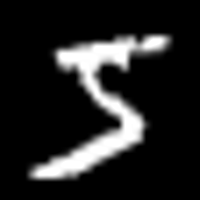

In [400]:
from PIL import Image

img = test_obj.get("image")
img.resize((200,200))

<h4> Creating a validation set </h4>

We need to split our training dataset in training and validation sets. This needs to be split randomly. We will use the ```np.random``` module from ```numpy```. We also need to transform our PIL images into PyTorch tensors. We do this by using the ```torchvision.transforms``` module. We will also normalize our data to make sure that our neural network can read each image correctly. The ```transforms.ToTensor()``` transformation makes pixels between 0 and 1. The normalized will standardize each pixel value. 

In [315]:
import torch
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

rng = np.random.default_rng()

train_vald_imgs_arr = [item.get('image') for item in train_dict]
train_vald_lbls_arr = [item.get('label') for item in train_dict]
train_vald = list(zip(train_vald_imgs_arr, train_vald_lbls_arr))
train_vald_arr = np.array(object = train_vald, dtype = tuple)
train_vald_arr[0:4]

array([[<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x470469D10>,
        5],
       [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x47046B390>,
        0],
       [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x47046B890>,
        4],
       [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x47046B610>,
        1]], dtype=object)

In [405]:
def valid_split(arr, split = 0.2):
    rng.shuffle(arr)
    split_ix = int(split * len(arr))
    return arr[0:split_ix], arr[split_ix:-1]

training_set, validation_set = valid_split(train_vald_arr)

training_img = torch.stack([transform(img_lbl_tpl[0]) for img_lbl_tpl in training_set]).view(-1, 28*28).float().requires_grad_()
validation_img = torch.stack([transform(img_lbl_tpl[0]) for img_lbl_tpl in validation_set]).view(-1, 28*28).float().requires_grad_()

training_lbls, validation_lbls = torch.tensor([img_lbl_tpl[1] for img_lbl_tpl in training_set]), torch.tensor([img_lbl_tpl[1] for img_lbl_tpl in validation_set])

train = list(zip(training_img, training_lbls))
valid = list(zip(validation_img, validation_lbls))

In [18]:
#Checking... #FerrariCore

print(f"The type of the first element of both sets are: train'{type(train[0])}', valid'{type(valid[0])}'")
print(f"The first element of each is a tensor: train'{type(train[0][0])}', valid '{type(valid[0][0])}'")
print(f"The second element of each tuple is an integer: train '{type(train[0][1])}', valid '{type(valid[0][1])}'")
print(f"The shape of both tensors are: train '{training_img.shape}, valid '{validation_img.shape}' ")

The type of the first element of both sets are: train'<class 'tuple'>', valid'<class 'tuple'>'
The first element of each is a tensor: train'<class 'torch.Tensor'>', valid '<class 'torch.Tensor'>'
The second element of each tuple is an integer: train '<class 'torch.Tensor'>', valid '<class 'torch.Tensor'>'
The shape of both tensors are: train 'torch.Size([12000, 784]), valid 'torch.Size([47999, 784])' 


<h2> Building Up The Neural Network  </h2>

In [ ]:
# Helper functions 
def init_params(size, std=1.0):
    """Initializes a random parameters for a given size of a PyTorch tensor
    
    SIZE: tuple --> gives the dimension of our tenso
    STD: float --> allows us to shift our parameters somewhat. Also needed to make sure that our parameters are floats."""
    return (torch.randn(size) * std).requires_grad_()

def first(dl):
    return next(iter(dl))

In [20]:
#Initializing weights and biases
weights = init_params((28*28,1))
bias = init_params(1)

In [ ]:
#Calculating prediction for one image using a linear function
(train[0][0] * weights.T).sum() + bias

tensor([-1426.4187], grad_fn=<AddBackward0>)

Since we are going to do this process with all of our tensors, we will use matrix multiplication. In python, we denote this with the symbol ```@```. 

Remember matrix multiplication rules:

For $A \times B$ to make sense, we need:

$$ A:[n \times p]$$
$$ B:[p \times m]$$

Thus, matrix $A$ needs to have the same number of columns as matrix $B$ has columns. 

In [ ]:
def linear1(xb):
    """A linear function that uses matrix multiplication.
    
    XB: tensor --> our input tensor. Returns a tensor of the same rank as XB x  weights"""
    return xb@weights + bias

def mse(pred, targets):
    return torch.mean((pred-targets)**2)

preds = linear1(training_img)
preds

tensor([[-1426.4186],
        [-1572.5239],
        [  108.1420],
        ...,
        [-1975.7198],
        [ -128.0186],
        [  787.5239]], grad_fn=<AddBackward0>)

We will use a PyTorch ```DataLoader``` to create batches. This is because we don't want to use every image for each loss calculation. This will allow us to get a more accurate and stable gradient calculation.

In [23]:
from torch.utils.data import DataLoader 

train_dl = DataLoader(train, batch_size=256)
input, target = first(train_dl)
input.shape, target.shape

(torch.Size([256, 784]), torch.Size([256]))

In [24]:
valid_dl = DataLoader(valid, batch_size=256)

batch_img = training_img[0:4]
batch_lbls = training_lbls[0:4]

In [ ]:
# How to calculate gradients with PyTorch
def calc_grad(x, target, model):
    pred = model(x)
    loss = mse(pred, target)
    loss.backward()

calc_grad(batch_img, batch_lbls, linear1)
weights.grad.mean(), bias.grad

(tensor(-85387.0938), tensor([-2608.0566]))

In [ ]:
# Re-initialize our parameter's gradients: PyTorch adds to the last calculated gradient
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

<h4> Creating a Stochastic Gradient Descent (SGD) Optimizer </h4>

SGD helps us minimize our loss function by updating our model. We start with random parameters for our model, calculate loss with this model, calculate the gradient, update our parameters in the opposite direction of our gradient. 

*Mathematically*

Our loss function: $ \text{Loss} = L(\vec{x}) $

Our model: $ \text{Model}(I) = \text{I} \cdot \text{Weights}^T +  \text{bias} $ 

$$ \nabla L = \langle a_1, a_2, a_3, ... , a_n \rangle$$

**Stochastic Gradient Descent formula**

*Update each parameter*
$$ \text{Weights} - \nabla L$$
$$ \text{bias} - \nabla L$$

The stochastic part of the optimzer is the random initialization.

In [32]:
# linear model from pytorch modules
import torch.nn as nn

linear_model = nn.Linear(28*28,1)

w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [ ]:
#Creating a SGD optimizer

class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [406]:
learning_rate = 0.1
opt = BasicOptim(linear_model.parameters(), learning_rate)

In [99]:
#simplified training loop using our optimzer
def train_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
validate_epoch = lambda model: "0.43"

def train_model(model, epochs: int): 
    for _ in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end = ' ')

In [101]:
train_model(linear_model, 20)

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

<h4> The Neural Net </h4>

The Neural Network is a layering of linear functions. We need to add a non-linearity (here the ReLU function) as a hidden layer to make sure that our subsequent layers can communicate with each other. This is also necessary for the *Universal Approximation Theorem* to hold. 

*Universal Approximation Theorem*

For any continuous function $f : [0,1]^d \rightarrow \mathbb{R}$ and any $\epsilon > 0 $, there exist a neural network with one hidden layer and a sufficient large number of hidden units $m$ which approximates $f$ on $[0,1]^d$ uniformly to within $\epsilon$. 

We will call the hidden layer is called the activation function. 

In [ ]:
w1, b1, w2, b2 = init_params((28*28,30)), init_params(30), init_params((30,1)), init_params(1)

def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(torch.tensor(0.0)) # --> this is the non-linearity, the ReLU function
    res = res@w2 + b2
    return res

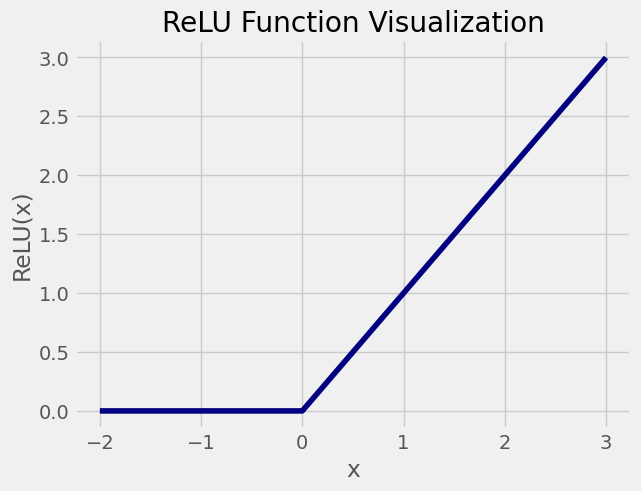

In [428]:
import matplotlib.pyplot as plt

x = np.linspace(-2, 3, 6)
y = np.maximum(0, x)

ReLU = plt.plot(x, y)
plt.setp(ReLU, color = 'navy')
plt.xlabel("x")
plt.ylabel("ReLU(x)")
plt.title("ReLU Function Visualization")
plt.grid(True)
plt.show()
plt.style.use("tableau-colorblind10")

In [ ]:
#Using Pytorch modules --> preferred
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1), 
)

w1, b1, w2, b2 = simple_net.parameters()
w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([30, 784]), torch.Size([30]), torch.Size([1, 30]), torch.Size([1]))

**Important notes**

1. The output activations of w1 (the second parameter in the first linear function) needs to be the same as the input activations of w2. Here, we have 30 to make sure that our layer can construct 30 different features. We can change this number to make our model more or less complex.

2. The simple neural network is our new model. It is our objective function! 

In [ ]:
#more complicated neural net example - 4 Layers

complex_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

<h2> Creating Our Own Implementation of The Learner Class </h2>

In [391]:
class Learner:
    def __init__(self, dataloaders, model, optimzer, loss, metrics):
        self.train = dataloaders[0]
        self.valid = dataloaders[1]
        self.model = model
        self.opt_type = optimzer
        self.loss_fn = loss
        self.metric_fn = metrics(self.valid)

    def train_epoch(self, opt):
            epoch_loss = np.array([])
            for xb, yb in self.train:
                opt.zero_grad()
                logits = self.model(xb)
                loss = self.loss_fn(logits, yb)
                loss.backward()
                epoch_loss = np.append(epoch_loss, loss.item())
                opt.step()
            return epoch_loss
    
    def fit(self, epochs:int, learning_rate):
        validate_epoch = self.metric_fn
        opt = self.opt_type(self.model, learning_rate)
        for ep in range(epochs):
            ep_mean_loss = np.mean(self.train_epoch(opt))
            print(f"Epoch #{ep} || Accuracy: {validate_epoch(self.model)} || Epoch Mean Loss: {ep_mean_loss}")
    
    #hide
    def __repr__(self):
        return f"Learner({(self.train, self.valid)}, {self.model}, {self.optimizer}, {self.loss}, {self.metrics})"
    
    def __str__(self):
         return (f"""<Learner for {self.model}: \n  
                        Optimizer: {self.optimizer.__name__} \n
                        Loss_func: {self.loss_fn.__name__} \n
                        Metrics: {self.metric_fn}
                """)

In [ ]:
#prepare our data using the torchvision datasets
from torchvision import transforms, datasets
from torch.utils.data import Dataset, random_split, DataLoader

mnist_train = datasets.MNIST(
    root=".", train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),                
        transforms.Normalize((0.1307,), (0.3081,))  
    ])
)

mnist_test = datasets.MNIST(
    root=".", train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),                
        transforms.Normalize((0.1307,), (0.3081,))  
    ])
)

train_size = int(len(mnist_train)*0.8)
val_size = int(len(mnist_train)*0.2)

train_set, valid_set = random_split(mnist_train, [train_size, val_size])

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=64, shuffle=True)

test = DataLoader(mnist_test, batch_size = 10, shuffle=True)

In [ ]:
#utils
def inference(xb):
    probs = torch.softmax(xb, dim=1)   
    return probs.argmax(dim=1) 

@torch.no_grad()
def metric_MNIST(xb, yb):
    preds = inference(xb)
    return (preds == yb).float().mean()

def make_metrics_fn(metrics_fn):
    def make_validate_epoch(validation_set):
        @torch.no_grad()
        def validate_epoch(model):
            accuracy = [metrics_fn(model(xb), yb) for xb,yb in validation_set]
            return round(torch.stack(accuracy).float().mean().item(), 4)
        return validate_epoch
    return make_validate_epoch

mnist_metrics = make_metrics_fn(metric_MNIST)
dataloaders = train_dl, valid_dl

In [ ]:
#testing scripts
from IPython.display import display

transform_PIL = transforms.Compose([transforms.ToPILImage()])

xb, yb = next(iter(test))

def test_MNIST(model):
    for i in range(len(xb)):
        pred = inference(model(xb[i])).item()
        target = yb[i].item()
        print(f"Our model predicted for the following input this: {pred}")
        display(transform_PIL(xb[i]).resize((150,150)))
        if pred != target:
            print(f"It was actually {target} \n")
        else:
            print(f"Correct! It was a {pred}")

In [395]:
simple_net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [396]:
def sgd(model, lr): 
    return torch.optim.SGD(model.parameters(), lr)

simple_learn = Learner(dataloaders, simple_net, sgd, nn.CrossEntropyLoss(), mnist_metrics)
simple_learn.fit(20, 0.1)

Epoch #0 || Accuracy: 0.954 || Epoch Mean Loss: 0.2899290070583423
Epoch #1 || Accuracy: 0.9586 || Epoch Mean Loss: 0.1279706464583675
Epoch #2 || Accuracy: 0.9673 || Epoch Mean Loss: 0.08922972599727412
Epoch #3 || Accuracy: 0.9673 || Epoch Mean Loss: 0.06773522248119115
Epoch #4 || Accuracy: 0.973 || Epoch Mean Loss: 0.053258074833701055
Epoch #5 || Accuracy: 0.9721 || Epoch Mean Loss: 0.043197303747447825
Epoch #6 || Accuracy: 0.9738 || Epoch Mean Loss: 0.0344271691457058
Epoch #7 || Accuracy: 0.9764 || Epoch Mean Loss: 0.027034978069365025
Epoch #8 || Accuracy: 0.9744 || Epoch Mean Loss: 0.02197771639392401
Epoch #9 || Accuracy: 0.9747 || Epoch Mean Loss: 0.017774942974870405
Epoch #10 || Accuracy: 0.9781 || Epoch Mean Loss: 0.014322115782337884
Epoch #11 || Accuracy: 0.9771 || Epoch Mean Loss: 0.01158492103376193
Epoch #12 || Accuracy: 0.9763 || Epoch Mean Loss: 0.009573907433388134
Epoch #13 || Accuracy: 0.9748 || Epoch Mean Loss: 0.007494971723606189
Epoch #14 || Accuracy: 0.976

In [ ]:
test_MNIST(simple_net)

<h4> Trying this on a more complex neural network (4 layers) </h4>

In [334]:
complex_net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256,10)
)

In [336]:
complex_learn = Learner(dataloaders, complex_net, nn.CrossEntropyLoss(), metric_MNIST)
complex_learn.fit(20, 0.1)

Epoch #0 || Accuracy: 0.9775
Epoch #1 || Accuracy: 0.9771
Epoch #2 || Accuracy: 0.9774
Epoch #3 || Accuracy: 0.9776
Epoch #4 || Accuracy: 0.9776
Epoch #5 || Accuracy: 0.9775
Epoch #6 || Accuracy: 0.9776
Epoch #7 || Accuracy: 0.9773
Epoch #8 || Accuracy: 0.9772
Epoch #9 || Accuracy: 0.9776
Epoch #10 || Accuracy: 0.9774
Epoch #11 || Accuracy: 0.9773
Epoch #12 || Accuracy: 0.9773
Epoch #13 || Accuracy: 0.9772
Epoch #14 || Accuracy: 0.9777
Epoch #15 || Accuracy: 0.9776
Epoch #16 || Accuracy: 0.9776
Epoch #17 || Accuracy: 0.9776
Epoch #18 || Accuracy: 0.9771
Epoch #19 || Accuracy: 0.9776


Our model predicted for the following input this: 6


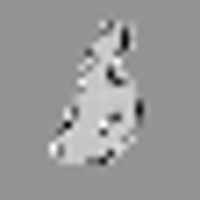

It was actually 6 

Our model predicted for the following input this: 7


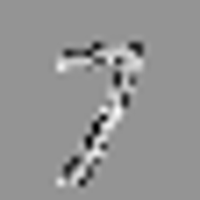

It was actually 7 

Our model predicted for the following input this: 7


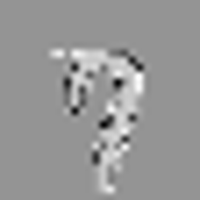

It was actually 7 

Our model predicted for the following input this: 4


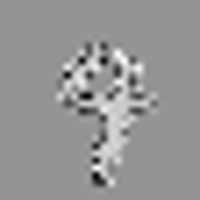

It was actually 4 

Our model predicted for the following input this: 4


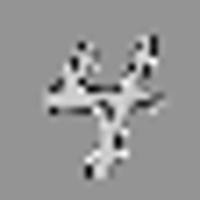

It was actually 4 

Our model predicted for the following input this: 1


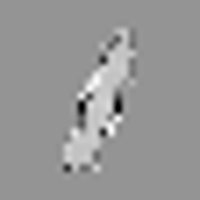

It was actually 1 

Our model predicted for the following input this: 5


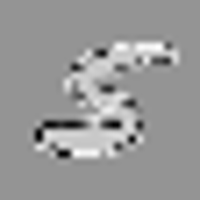

It was actually 5 

Our model predicted for the following input this: 8


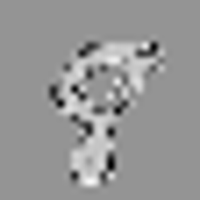

It was actually 8 

Our model predicted for the following input this: 4


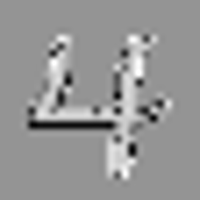

It was actually 4 

Our model predicted for the following input this: 5


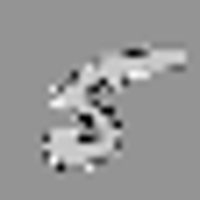

It was actually 5 



In [337]:
test_MNIST(complex_net)